# Sparkify Customer Churn Prediction

This notebook uses the `medium_sparkify_event_data` dataset.

-----


## Project Overview
Predicting churn rates is a challenging and common problem that data scientists and analysts regularly encounter in any customer-facing business. The ability to identify customer who are about to churn is essential for any business that want's to keep itself relevant. It is known that acquiring new customers is more expensive than keeping the ones you already have. With that in mind, the goal of this project is to help the fictional Sparkify music service to retain it's customers. In order to do that, I analyzed Sparkify's data and built a machine learning model to predict if a particular customer will abandon the service in the future and act upon it.

In [1]:
import ibmos2spark, os
# @hidden_cell
credentials = {
    'endpoint': 'https://s3.private.us.cloud-object-storage.appdomain.cloud',
    'service_id': 'iam-ServiceId-24fcb16b-ab46-470e-b4ac-ef8bd3667380',
    'iam_service_endpoint': 'https://iam.cloud.ibm.com/oidc/token',
    'api_key': 'vY-2Cdjxr9s1iAfobqej-gqsRsKiLF_LR0q-capWCI-T'
}

configuration_name = 'os_4dbe7118ea514d6981376fb687f89ff3_configs'
cos = ibmos2spark.CloudObjectStorage(sc, credentials, configuration_name, 'bluemix_cos')

from pyspark.sql import SparkSession
spark = SparkSession.builder.getOrCreate()
# Since JSON data can be semi-structured and contain additional metadata, it is possible that you might face issues with the DataFrame layout.
# Please read the documentation of 'SparkSession.read()' to learn more about the possibilities to adjust the data loading.
# PySpark documentation: http://spark.apache.org/docs/2.0.2/api/python/pyspark.sql.html#pyspark.sql.DataFrameReader.json

df_data_1 = spark.read.json(cos.url('medium-sparkify-event-data.json', 'sparkify-donotdelete-pr-drpbymj31vmdoc'))
df_data_1.take(5)
# Sparkfiy Customer Churn Project

[Row(artist='Martin Orford', auth='Logged In', firstName='Joseph', gender='M', itemInSession=20, lastName='Morales', length=597.55057, level='free', location='Corpus Christi, TX', method='PUT', page='NextSong', registration=1532063507000, sessionId=292, song='Grand Designs', status=200, ts=1538352011000, userAgent='"Mozilla/5.0 (Macintosh; Intel Mac OS X 10_9_4) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/36.0.1985.125 Safari/537.36"', userId='293'),
 Row(artist="John Brown's Body", auth='Logged In', firstName='Sawyer', gender='M', itemInSession=74, lastName='Larson', length=380.21179, level='free', location='Houston-The Woodlands-Sugar Land, TX', method='PUT', page='NextSong', registration=1538069638000, sessionId=97, song='Bulls', status=200, ts=1538352025000, userAgent='"Mozilla/5.0 (Macintosh; Intel Mac OS X 10_9_4) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/36.0.1985.143 Safari/537.36"', userId='98'),
 Row(artist='Afroman', auth='Logged In', firstName='Maverick', gender='M', 

In [2]:
# importing libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime

# pyspark
from pyspark.sql import Window
from pyspark.sql.functions import *
from pyspark.sql.functions import min as min_, max as max_ 
from pyspark.sql.types import IntegerType, StringType

# machine learning 
from pyspark.ml import Pipeline
from pyspark.ml.classification import LogisticRegression, RandomForestClassifier, LinearSVC, NaiveBayes
from pyspark.ml.feature import VectorAssembler, StringIndexer, Normalizer, StandardScaler, MinMaxScaler, OneHotEncoder
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

## 1. Loading Dataset

In [3]:
df = df_data_1
df.printSchema()

root
 |-- artist: string (nullable = true)
 |-- auth: string (nullable = true)
 |-- firstName: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- itemInSession: long (nullable = true)
 |-- lastName: string (nullable = true)
 |-- length: double (nullable = true)
 |-- level: string (nullable = true)
 |-- location: string (nullable = true)
 |-- method: string (nullable = true)
 |-- page: string (nullable = true)
 |-- registration: long (nullable = true)
 |-- sessionId: long (nullable = true)
 |-- song: string (nullable = true)
 |-- status: long (nullable = true)
 |-- ts: long (nullable = true)
 |-- userAgent: string (nullable = true)
 |-- userId: string (nullable = true)



### Dataset Description: 

|#| Column | Type | Description |
| --- | --- | --- | --- |
| 1 | userId | string | Unique identifier of the user, the event is related to |
| 2 | artist | string | Name of the artist related to the song related to the event |
| 3 | auth | string | “Logged in” or “Cancelled” |
| 4 | firstName | string | First name of the user |
| 5 | gender | string | Gender of the user, “F” or “M” |
| 6 | itemInSession | bigint | Item in session |
| 7 | lastName | string | Last name of the user |
| 8 | length | double | Length of the song related to the event |
| 9 | level | string | Level of the user’s subscription, “free” or “paid”. User can change the level, so events for the same user can have different levels |
| 10 | location | string | Location of the user at the time of the event |
| 11 | method | string | “GET” or “PUT” |
| 12 | page | string | Type of action: “NextSong”, “Login”, “Thumbs Up” etc. |
| 13 | registration | bigint | Registration |
| 14 | sessionId | bigint | Session id|
| 15 | song | string | Name of the song related to the event |
| 16 | status | bigint | Response status: 200, 404, 307 |
| 17 | ts | bigint | Timestamp of the event |
| 18 | userAgent | string | Agent, which user used for the event, for example, “Mozilla/5.0” |

## 2. Cleaning Dataset
### 2.1 Checking for Missing Values

In [4]:
# number of nulls for each column
nulls = {col: df.filter(df[col].isNull()).count() for col in df.columns}
nulls

{'artist': 110828,
 'auth': 0,
 'firstName': 15700,
 'gender': 15700,
 'itemInSession': 0,
 'lastName': 15700,
 'length': 110828,
 'level': 0,
 'location': 15700,
 'method': 0,
 'page': 0,
 'registration': 15700,
 'sessionId': 0,
 'song': 110828,
 'status': 0,
 'ts': 0,
 'userAgent': 15700,
 'userId': 0}

**We can see two cases here:**
1. There are `58392` rows that are not associated with any artist or song. That is expected considering that there are actions that are not related to listening to music.
2. There are `8346` rows where there are not firstName, lastName, gender and any other user related information. This is very likelly a problem with the data. Let's check it.

In [5]:
df.where(df.firstName.isNull() == True).select(['userId','firstName','lastName','gender','location',
                                                'auth','level','method','page']).show()

+------+---------+--------+------+--------+----------+-----+------+-----+
|userId|firstName|lastName|gender|location|      auth|level|method| page|
+------+---------+--------+------+--------+----------+-----+------+-----+
|      |     null|    null|  null|    null|Logged Out| paid|   GET| Home|
|      |     null|    null|  null|    null|Logged Out| paid|   GET| Home|
|      |     null|    null|  null|    null|Logged Out| paid|   GET| Home|
|      |     null|    null|  null|    null|Logged Out| paid|   PUT|Login|
|      |     null|    null|  null|    null|Logged Out| free|   GET| Home|
|      |     null|    null|  null|    null|Logged Out| free|   GET| Home|
|      |     null|    null|  null|    null|Logged Out| free|   GET| Help|
|      |     null|    null|  null|    null|Logged Out| free|   GET| Home|
|      |     null|    null|  null|    null|Logged Out| free|   GET|About|
|      |     null|    null|  null|    null|Logged Out| free|   PUT|Login|
|      |     null|    null|  null|    

**Observations**:
- There is clearly a problem here. All these records where there's no `userId` are rows that the user probably wasn't logged in. I'm going to drop these values.

### 2.2 Dropping Missing Values

In [6]:
df = df.dropna(how='any', subset=['firstName', 'lastName', 'gender', 'location', 'userAgent', 'registration'])

# checking once again the number of nulls in each column
nulls = {col: df.filter(df[col].isNull()).count() for col in df.columns}
nulls

{'artist': 95128,
 'auth': 0,
 'firstName': 0,
 'gender': 0,
 'itemInSession': 0,
 'lastName': 0,
 'length': 95128,
 'level': 0,
 'location': 0,
 'method': 0,
 'page': 0,
 'registration': 0,
 'sessionId': 0,
 'song': 95128,
 'status': 0,
 'ts': 0,
 'userAgent': 0,
 'userId': 0}

### 2.3 Checking Numerical Columns

In [7]:
df.describe(['itemInSession', 'length', 'registration', 'sessionId', 'status']).show()

+-------+------------------+------------------+--------------------+------------------+------------------+
|summary|     itemInSession|            length|        registration|         sessionId|            status|
+-------+------------------+------------------+--------------------+------------------+------------------+
|  count|            528005|            432877|              528005|            528005|            528005|
|   mean|107.77899451709737|248.66459278007738|1.535523414862437E12|2042.9801820058522|209.09106163767387|
| stddev| 116.8647866296988| 98.41266955051972|3.0787254929957166E9|1433.9981489410682|30.148777830591797|
|    min|                 0|           0.78322|       1509854193000|                 1|               200|
|    max|              1005|        3024.66567|       1543073874000|              4808|               404|
+-------+------------------+------------------+--------------------+------------------+------------------+



In [8]:
df.describe(['ts']).show()

+-------+--------------------+
|summary|                  ts|
+-------+--------------------+
|  count|              528005|
|   mean|1.540966927748435...|
| stddev|1.4812330940351417E9|
|    min|       1538352011000|
|    max|       1543622466000|
+-------+--------------------+



**observations**:
- Everything looks to be ok with the numerical columns. No data cleaning is needed here.

## 3. Exploratory Data Analysis
### 3.1 Defining Churn 
In order to define churn, the `Cancellation Confirmation` event will be used. 

In [9]:
# getting all users who cancelled the plan
users_cancelled = df.filter(df.page == "Cancellation Confirmation").select(['userId', 'auth', 'page']).distinct()
users_cancelled.show(10)

+------+---------+--------------------+
|userId|     auth|                page|
+------+---------+--------------------+
|100024|Cancelled|Cancellation Conf...|
|100011|Cancelled|Cancellation Conf...|
|   288|Cancelled|Cancellation Conf...|
|200021|Cancelled|Cancellation Conf...|
|200024|Cancelled|Cancellation Conf...|
|100051|Cancelled|Cancellation Conf...|
|200041|Cancelled|Cancellation Conf...|
|100030|Cancelled|Cancellation Conf...|
|    41|Cancelled|Cancellation Conf...|
|100040|Cancelled|Cancellation Conf...|
+------+---------+--------------------+
only showing top 10 rows



In [10]:
# creating list with all userIds who cancelled the plan
users_cancelled = users_cancelled.select("userId").toPandas().values
print(f'Number of users who churned in the dataset: {len(users_cancelled)}')

Number of users who churned in the dataset: 99


In [11]:
# function to define churn column
cancelled = udf(lambda x: 1 if x in users_cancelled else 0)

# using function on dataset
df = df.withColumn('churn', cancelled('userId'))

# showing churned customers
df.filter(df.churn == 1).select(['userId', 'firstName', 'lastName', 'gender', 'auth', 'level', 'churn']).distinct().show(10)

+------+---------+--------+------+---------+-----+-----+
|userId|firstName|lastName|gender|     auth|level|churn|
+------+---------+--------+------+---------+-----+-----+
|    32|    Diego|   Mckee|     M|Logged In| free|    1|
|    88|   Zyonna|    Bird|     F|Logged In| paid|    1|
|   130|     Ivan| Sanchez|     M|Cancelled| free|    1|
|   132|    Sadie|   Jones|     F|Cancelled| paid|    1|
|    81|   Oliver| Gilbert|     M|Logged In| paid|    1|
|   154|   Oliver|     Fry|     M|Logged In| free|    1|
|    13|    Anika| Osborne|     F|Logged In| free|    1|
|   200|    Isaac|  Miller|     M|Cancelled| paid|    1|
|    13|    Anika| Osborne|     F|Logged In| paid|    1|
|    11|      Zoe|   Patel|     F|Logged In| free|    1|
+------+---------+--------+------+---------+-----+-----+
only showing top 10 rows



In [12]:
# checking multiple rows of the same user
df.filter(df.userId == '122').select(['userId', 'firstName', 'page', 'churn']).toPandas().head()

,userId,firstName,page,churn
0,122,Molly,Home,0
1,122,Molly,NextSong,0
2,122,Molly,NextSong,0
3,122,Molly,NextSong,0
4,122,Molly,NextSong,0


Ok, now that I have a churn column, let's explore the data!

### 3.2 Explore Data

#### 3.2.1 Amount of users who Churned 

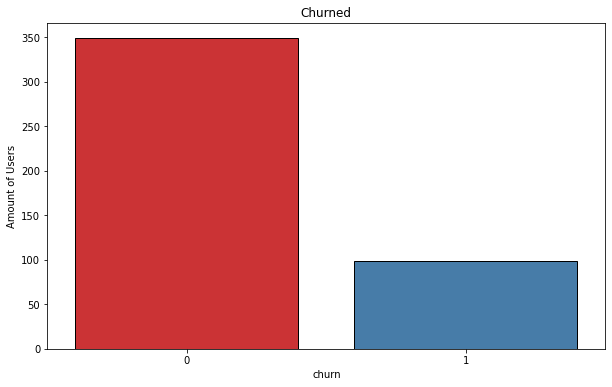

In [13]:
# data
pdf1 = df.select(['userId', 'churn']).distinct().groupby('churn').count().toPandas()

# plot
plt.figure(figsize=(10,6))
sns.barplot(data=pdf1, x='churn', y='count', palette='Set1', edgecolor=['black', 'black'])
plt.title('Churned', size=12)
plt.ylabel('Amount of Users')
plt.show()

**Comments:**
- As we can see, the dataset is imbalanced, so I'll need to use the f1 score as the evaluation metric.

#### 3.2.2 Churned x Stayed by Gender

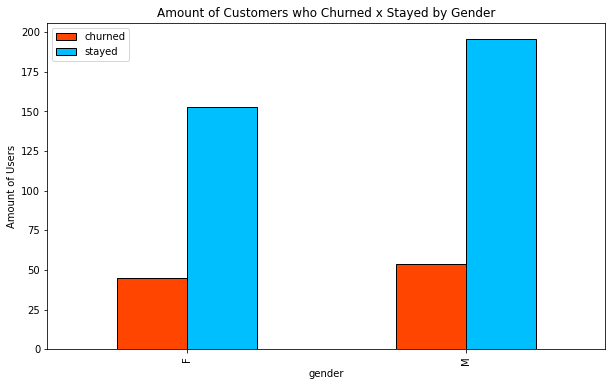

In [14]:
# data 
churned = df.where(df['churn']==1).dropDuplicates(['userId']).groupby('gender').count().withColumnRenamed('count', 'churned').toPandas()
stayed = df.where(df['churn']==0).dropDuplicates(['userId']).groupby('gender').count().withColumnRenamed('count', 'stayed').toPandas()

# plot
churned.merge(stayed).plot(kind='bar', x='gender', color=['orangered', 'deepskyblue'], edgecolor=['black','black'], figsize=(10,6))
plt.title('Amount of Customers who Churned x Stayed by Gender', size=12)
plt.ylabel('Amount of Users')
plt.show()

**Comments:**
- We can see that there are more male customers.
- We can also see that female customers have a higher chance of churning because of the proportions.

#### 3.2.3 Churned x Stayed by Level

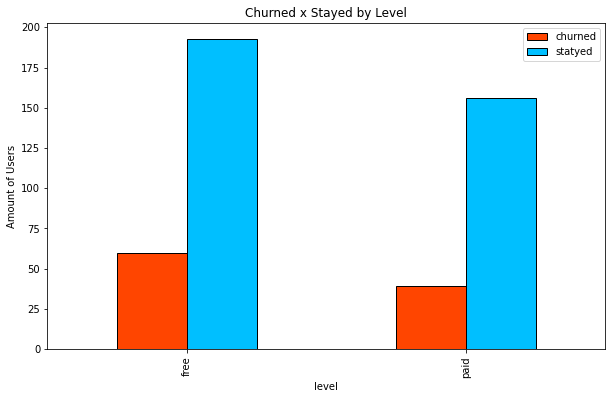

In [15]:
# data
churned = df.where(df.churn==1).dropDuplicates(['userId']).groupby('level').count().withColumnRenamed('count', 'churned').toPandas()
stayed = df.where(df.churn==0).dropDuplicates(['userId']).groupby('level').count().withColumnRenamed('count', 'statyed').toPandas()

# plot
churned.merge(stayed).plot(kind='bar', x='level', color=['orangered', 'deepskyblue'], edgecolor=['black', 'black'], figsize=(10,6))
plt.title('Churned x Stayed by Level', size=12)
plt.ylabel('Amount of Users')
plt.show()

**Comments:**
- We can see from this plot that free customers also have a higher chance of churning.

#### 3.2.4 Amount of Churns for each Page

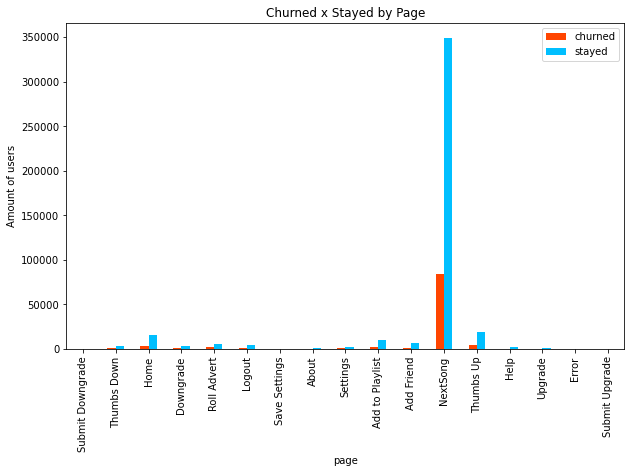

In [16]:
# data
churned = df.where(df.churn == 1).groupby('page').count().withColumnRenamed('count', 'churned').toPandas()
stayed = df.where(df.churn == 0).groupby('page').count().withColumnRenamed('count', 'stayed').toPandas()

# plot
churned.merge(stayed).plot(kind='bar', x='page', color=['orangered', 'deepskyblue'], figsize=(10,6))
plt.title('Churned x Stayed by Page', size=12)
plt.ylabel('Amount of users')
plt.show()

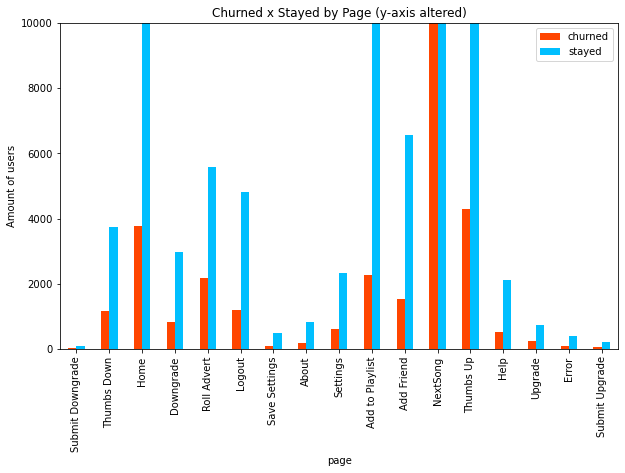

In [17]:
# plot
churned.merge(stayed).plot(kind='bar', x='page', color=['orangered', 'deepskyblue'], figsize=(10,6))
plt.title('Churned x Stayed by Page (y-axis altered)', size=12)
plt.ylabel('Amount of users')
plt.ylim(0, 10000)
plt.show()

**Comments:**
- We can see from the plot that there are a few pages with a higher proportio of churners, like the Roll Avert.

#### 3.2.5 Amount of Churns for each Location

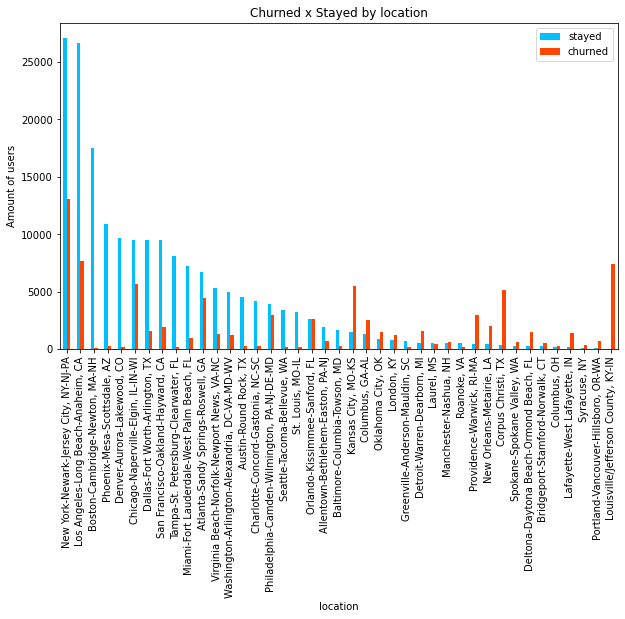

In [18]:
# data
churned = df.where(df.churn == 1).groupby('location').count().withColumnRenamed('count', 'churned').toPandas()
stayed = df.where(df.churn == 0).groupby('location').count().withColumnRenamed('count', 'stayed').sort('stayed', ascending=False).toPandas()

# plot
stayed.merge(churned).plot(kind='bar', x='location', color=['deepskyblue', 'orangered'], figsize=(10,6))
plt.title('Churned x Stayed by location', size=12)
plt.ylabel('Amount of users')
plt.show()

**Comments:**
- There are some locaitons that have much more churners or maybe only churners, like Loisville and Kansas City.

#### 3.2.6 Amount of Churns for each Method

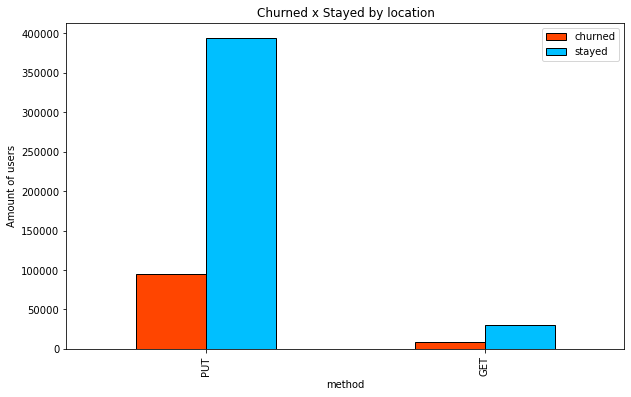

In [19]:
# data
churned = df.where(df.churn == 1).groupby('method').count().withColumnRenamed('count', 'churned').toPandas()
stayed = df.where(df.churn == 0).groupby('method').count().withColumnRenamed('count', 'stayed').toPandas()

# plot
churned.merge(stayed).plot(kind='bar', x='method', color=['orangered', 'deepskyblue'], edgecolor=['black', 'black'], figsize=(10,6))
plt.title('Churned x Stayed by location', size=12)
plt.ylabel('Amount of users')
plt.show()

**Comments:**
- The get method has a much higher churning rate. 

#### 3.2.7 Average Amount of Songs Listened by Churned x Stayed

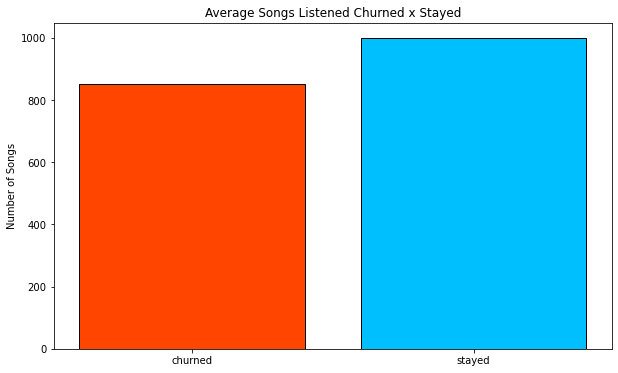

In [20]:
# data
churned = df.where((df.page=='NextSong') & (df.churn==1)).groupby('userId').count().select(avg('count')).withColumnRenamed('avg(count)','avg(churned)').toPandas()
stayed = df.where((df.page=='NextSong')&(df.churn==0)).groupby('userId').count().select(avg('count')).withColumnRenamed('avg(count)','avg(churned)').toPandas()

pdf2 = {
    'churned':churned.values[0][0],
    'stayed':stayed.values[0][0]
}
pdf2 = pd.DataFrame(pdf2, index=['avg_songs']).T

# plot
plt.figure(figsize=(10,6))
plt.bar(x=pdf2.index, height=pdf2.avg_songs, color=['orangered', 'deepskyblue'], edgecolor=['black', 'black'])
plt.title('Average Songs Listened Churned x Stayed', size=12)
plt.ylabel('Number of Songs')
plt.show()

**Comments:**
- People who churn listen to fewer songs

#### 3.2.8 Top 5 Artists Listened by Churned x Stayed

/opt/ibm/conda/miniconda/lib/python/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 131 (\x83) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


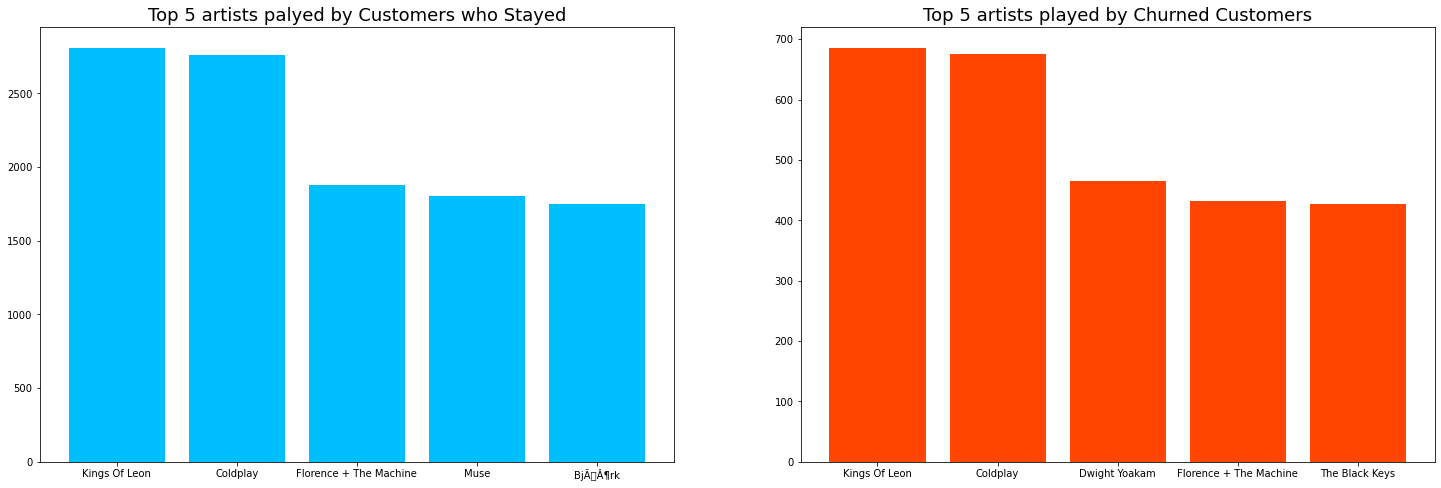

In [21]:
# data
churned = df.where((df.churn==1)&(df.artist.isNotNull())).groupby(df.artist).count().withColumnRenamed('count', 'churned').sort('churned', ascending=False).toPandas()
stayed = df.where((df.churn==0)&(df.artist.isNotNull())).groupby(df.artist).count().withColumnRenamed('count', 'stayed').sort('stayed', ascending=False).toPandas()

# plot
fig, axs = plt.subplots(1, 2, figsize=(25,8))
axs[0].bar(stayed.artist.head(), stayed.stayed.head(), color='deepskyblue')
axs[1].bar(churned.artist.head(), churned.churned.head(), color='orangered')

axs[0].set_title('Top 5 artists palyed by Customers who Stayed', size=18)
axs[1].set_title('Top 5 artists played by Churned Customers', size=18)

plt.show()

**Comments:**
- People who churn listen to the same songs as who doesn't.

#### 3.2.9 Top 5 Songs Listened by Churned x Stayed

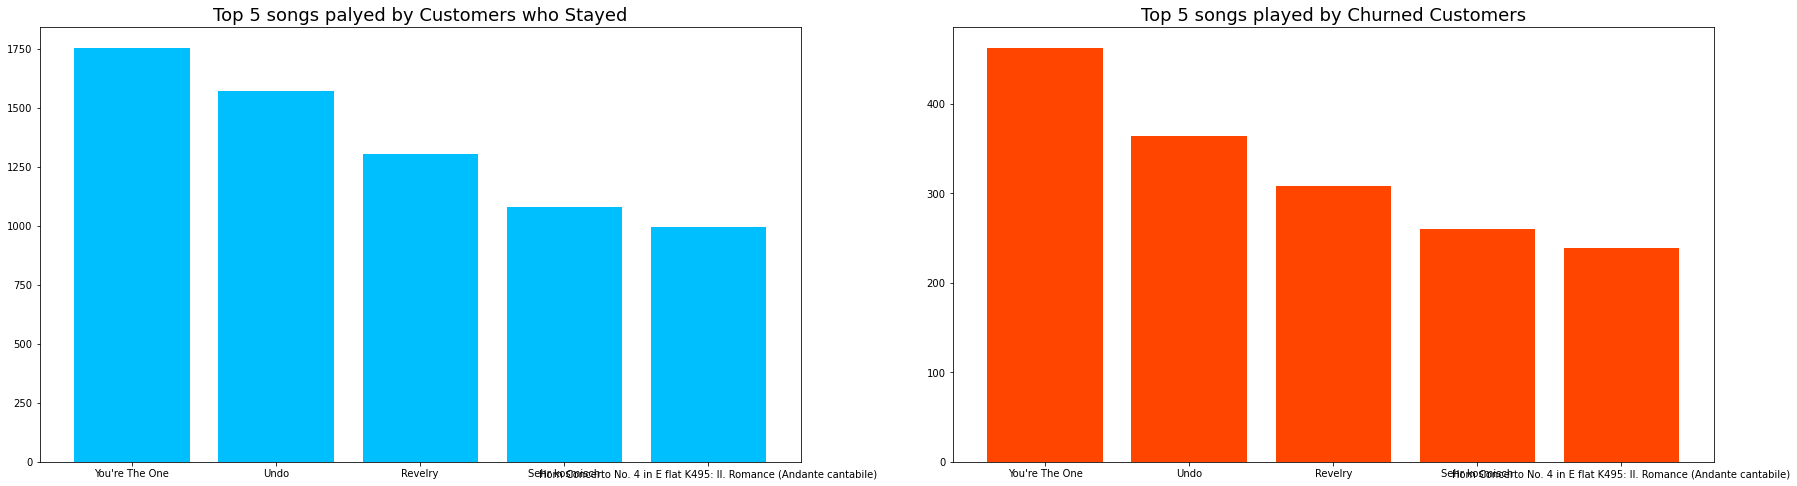

In [22]:
# data
churned = df.where((df.churn==1)&(df.song.isNotNull())).groupby(df.song).count().withColumnRenamed('count', 'churned').sort('churned', ascending=False).toPandas()
stayed = df.where((df.churn==0)&(df.song.isNotNull())).groupby(df.song).count().withColumnRenamed('count', 'stayed').sort('stayed', ascending=False).toPandas()

# plot
fig, axs = plt.subplots(1, 2, figsize=(30,8))
axs[0].bar(stayed.song.head(), stayed.stayed.head(), color='deepskyblue')
axs[1].bar(churned.song.head(), churned.churned.head(), color='orangered')

axs[0].set_title('Top 5 songs palyed by Customers who Stayed', size=18)
axs[1].set_title('Top 5 songs played by Churned Customers', size=18)

plt.show()

**Comments:**
- People who churn listen to the same artists as who doesn't 

#### 3.2.10 Average Song Length Listened by Churned x Stayed

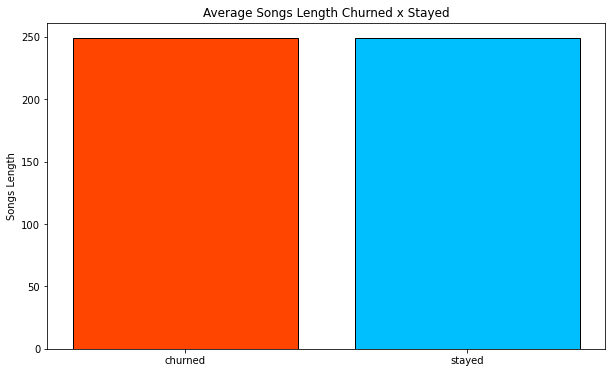

In [23]:
# data
churned = df.where((df.page=='NextSong')&(df.churn==1)).select(avg('length')).withColumnRenamed('avg(length)','avg(churned)').toPandas()
stayed = df.where((df.page=='NextSong')&(df.churn==1)).select(avg('length')).withColumnRenamed('avg(lenght)', 'avg(stayed)').toPandas()
pdf4 = pd.DataFrame({'churned': churned.values[0][0], 'stayed': stayed.values[0][0]}, index=['avg_length']).T

# plot
plt.figure(figsize=(10,6))
plt.bar(x=pdf4.index, height=pdf4.avg_length, color=['orangered', 'deepskyblue'], edgecolor=['black', 'black'])
plt.title('Average Songs Length Churned x Stayed', size=12)
plt.ylabel('Songs Length')
plt.show()

## 4. Feature Engineering

Now it's time to build the features necessary to predict if either a customer will churn or not. The features are the following:
1. `nThumbsUp`: Amount of Thumbs Up actions the user took.
2. `nThumbsDown`: Amount of Thumbs Down actions the user took.
3. `nSongs`: Amount of songs the user has listened.
4. `nPlaylist`: Amount of songs the user added to a playlist.
5. `nFriends`: Amount of friends the user has.
6. `nLogins`: Amount of times the user made login in the website.
7. `timeActive`: Time the user has been a client of Sparkify.
8. `lastLocation`: Last state the user has made login.
9. `lastLevel`: Last level (free or paid) the user was.
10. `gender`: Gender of the user.
11. `downgraded`: If the user has downgraded before.
12. `upgraded`: If the user has upgraded before.

#### 4.1 nThumbsUp

In [24]:
df_nThumbsUp = df.where(df.page=='Thumbs Up').groupBy('userId').count().withColumnRenamed('count', 'nThumbsUp').sort('userId')
df_nThumbsUp.show(10)
print(df_nThumbsUp.count())

+------+---------+
|userId|nThumbsUp|
+------+---------+
|    10|       17|
|   100|      143|
|100001|        5|
|100002|        8|
|100003|       16|
|100004|       15|
|100005|        2|
|100006|       14|
|100007|       40|
|100008|       19|
+------+---------+
only showing top 10 rows

439


#### 4.2 nThumbsDown

In [25]:
df_nThumbsDown = df.where(df.page=='Thumbs Down').groupBy('userId').count().sort('userId').withColumnRenamed('count', 'nThumbsDown')
df_nThumbsDown.show(10)
print(df_nThumbsDown.count())

+------+-----------+
|userId|nThumbsDown|
+------+-----------+
|    10|          1|
|   100|         37|
|100001|          1|
|100002|          2|
|100003|         10|
|100004|          2|
|100005|          1|
|100006|          3|
|100007|          6|
|100008|          5|
+------+-----------+
only showing top 10 rows

389


#### 4.3 nSongs

In [26]:
df_nSongs = df.where(df.page == 'NextSong').groupby('userId').count().sort('userId').withColumnRenamed('count', 'nSongs')
df_nSongs.show(10)
print(df_nSongs.count())

+------+------+
|userId|nSongs|
+------+------+
|    10|   360|
|   100|  3382|
|100001|    96|
|100002|   137|
|100003|   661|
|100004|   262|
|100005|    72|
|100006|   295|
|100007|   853|
|100008|   386|
+------+------+
only showing top 10 rows

448


#### 4.4 nPlaylist

In [27]:
df_nPlaylist = df.where(df.page == 'Add to Playlist').groupby('userId').count().sort('UserId').withColumnRenamed('count', 'nPlaylist')
df_nPlaylist.show(10)
print(df_nPlaylist.count())


+------+---------+
|userId|nPlaylist|
+------+---------+
|    10|       14|
|   100|       94|
|100001|        3|
|100002|        3|
|100003|       19|
|100004|        7|
|100005|        1|
|100006|        2|
|100007|       27|
|100008|       11|
+------+---------+
only showing top 10 rows

428


#### 4.5 nFriends

In [28]:
df_nFriends = df.where(df.page == 'Add Friend').groupby('userId').count().sort('userId').withColumnRenamed('count', 'nFriends')
df_nFriends.show(10)
print(df_nFriends.count())


+------+--------+
|userId|nFriends|
+------+--------+
|    10|       3|
|   100|      71|
|100001|       1|
|100003|       8|
|100004|       7|
|100006|       1|
|100007|      10|
|100008|      10|
|100009|      42|
|100010|       3|
+------+--------+
only showing top 10 rows

409


#### 4.6 nLogins

In [29]:
df_nLogins = df.where(df.page == 'Home').groupby('userId').count().sort('userId').withColumnRenamed('count', 'nLogins')
df_nLogins.show(10)
print(df_nLogins.count())

+------+-------+
|userId|nLogins|
+------+-------+
|    10|     15|
|   100|    135|
|100001|      4|
|100002|     12|
|100003|     31|
|100004|     17|
|100005|      3|
|100006|     12|
|100007|     42|
|100008|     15|
+------+-------+
only showing top 10 rows

440


#### 4.7 timeActive

In [30]:
# get first and last timestamp for each user
w = Window.partitionBy('userId')
df = df.withColumn('firsTs', min_('ts').over(w))
df = df.withColumn('lasTs', max_('ts').over(w))

# get date from first and last timestamps
getDate = udf(lambda x: str(datetime.datetime.utcfromtimestamp(x / 1000).strftime('%Y-%m-%d')), StringType())

df = df.withColumn('firstDate', getDate('firsTs'))
df = df.withColumn('lastDate', getDate('lasTs'))

# get the date diffence for each user
df = df.withColumn('timeActive', datediff(to_date('lastDate'), to_date('firstDate')))
df_timeActive = df.select('userId', 'timeActive').distinct().sort('userId')
df_timeActive.show(10)
print(df_timeActive.count())

+------+----------+
|userId|timeActive|
+------+----------+
|    10|         1|
|   100|        60|
|100001|         1|
|100002|        24|
|100003|        30|
|100004|        11|
|100005|         5|
|100006|        56|
|100007|        58|
|100008|        58|
+------+----------+
only showing top 10 rows

448


#### 4.8 lastLocation

In [31]:
# get state from location
state = udf(lambda x: x.split()[-1].split(' ')[-1].split('-')[-1])
df = df.withColumn('state', state('location'))
df_lastLocation = df.filter('ts == lasTs').select('userId','state').distinct().withColumnRenamed('state', 'lastLocation').sort('userId')
df_lastLocation.show(10)
print(df_lastLocation.count())


+------+------------+
|userId|lastLocation|
+------+------------+
|    10|          MS|
|   100|          TX|
|100001|          FL|
|100002|          CA|
|100003|          FL|
|100004|          NY|
|100005|          LA|
|100006|          MI|
|100007|          AR|
|100008|          CA|
+------+------------+
only showing top 10 rows

448


#### 4.9 lastLevel

In [32]:
df_lastLevel = df.filter('ts==lasTs').select('userId', 'level').distinct().withColumnRenamed('level', 'lastLevel').sort('userId')
df_lastLevel.show(10)
print(df_lastLevel.count())

+------+---------+
|userId|lastLevel|
+------+---------+
|    10|     paid|
|   100|     paid|
|100001|     free|
|100002|     free|
|100003|     paid|
|100004|     free|
|100005|     free|
|100006|     free|
|100007|     free|
|100008|     paid|
+------+---------+
only showing top 10 rows

448


#### 4.10 gender

In [33]:
df_gender = df.select('userId', 'gender').distinct().sort('userId')
df_gender.show(10)
print(df_gender.count())

+------+------+
|userId|gender|
+------+------+
|    10|     M|
|   100|     M|
|100001|     F|
|100002|     F|
|100003|     F|
|100004|     F|
|100005|     M|
|100006|     F|
|100007|     F|
|100008|     F|
+------+------+
only showing top 10 rows

448


#### 4.11 downgraded

In [34]:
# list of users who downgraded
users_downgraded = df.where(df.page=='Submit Downgrade').select('userId', 'ts').distinct().toPandas().userId.values

# downgraded udf
downgraded = udf(lambda x: 1 if x in users_downgraded else 0)

# using udf on dataset
df = df.withColumn('downgraded', downgraded('userId'))
df_downgraded = df.select('userId', 'downgraded').distinct().sort('userId')

# results
df_downgraded.show(10)
print(df_downgraded.count())

+------+----------+
|userId|downgraded|
+------+----------+
|    10|         0|
|   100|         0|
|100001|         0|
|100002|         1|
|100003|         0|
|100004|         0|
|100005|         0|
|100006|         1|
|100007|         1|
|100008|         0|
+------+----------+
only showing top 10 rows

448


#### 4.12 upgraded

In [35]:
# list of users who upgraded
users_upgraded = df.where(df.page=='Submit Upgrade').select('userId', 'ts').distinct().toPandas().userId.values

# upgraded udf
upgraded = udf(lambda x: 1 if x in users_upgraded else 0)

# using udf on dataset
df = df.withColumn('upgraded', upgraded('userId'))
df_upgraded = df.select('userId', 'upgraded').distinct().sort('userId')

# results
df_upgraded.show(10)
print(df_upgraded.count())

+------+--------+
|userId|upgraded|
+------+--------+
|    10|       0|
|   100|       1|
|100001|       0|
|100002|       1|
|100003|       1|
|100004|       0|
|100005|       0|
|100006|       1|
|100007|       1|
|100008|       0|
+------+--------+
only showing top 10 rows

448


### 4.13 Building the final dataframe

In [36]:
df_final = df.select('userId', 'churn').distinct()
df_final = df_final.join(df_nThumbsUp, ['userId'], how='left')
df_final = df_final.join(df_nThumbsDown, ['userId'], how='left')
df_final = df_final.join(df_nSongs, ['userId'], how='left')
df_final = df_final.join(df_nFriends, ['userId'], how='left')
df_final = df_final.join(df_nLogins, ['userId'], how='left')
df_final = df_final.join(df_nPlaylist, ['userId'], how='left')
df_final = df_final.join(df_timeActive, ['userId'], how='left')
df_final = df_final.join(df_lastLocation, ['userId'], how='left')
df_final = df_final.join(df_lastLevel, ['userId'], how='left')
df_final = df_final.join(df_gender, ['userId'], how='left')
df_final = df_final.join(df_upgraded, ['userId'], how='left')
df_final = df_final.join(df_downgraded, ['userId'], how='left')
df_final.show(10)

+------+-----+---------+-----------+------+--------+-------+---------+----------+------------+---------+------+--------+----------+
|userId|churn|nThumbsUp|nThumbsDown|nSongs|nFriends|nLogins|nPlaylist|timeActive|lastLocation|lastLevel|gender|upgraded|downgraded|
+------+-----+---------+-----------+------+--------+-------+---------+----------+------------+---------+------+--------+----------+
|   139|    0|       11|          3|   259|       9|     12|        8|        47|          CA|     free|     M|       1|         1|
|   298|    0|       29|         12|   736|      16|     36|       22|        52|          NC|     paid|     F|       1|         0|
|300001|    0|      140|         11|  1623|      29|     71|       39|        60|          CO|     paid|     F|       1|         1|
|   158|    0|        5|          2|    89|       3|     10|        2|        39|          PA|     free|     M|       0|         0|
|   165|    0|       19|          3|   285|       5|     20|        8|      

### 4.14 Filling final dataframe missing values

In [37]:
df_final = df_final.fillna(0, subset=['nThumbsUp', 'nThumbsDown', 'nFriends', 'nLogins', 'nPlaylist'])
df_final.show(10)

+------+-----+---------+-----------+------+--------+-------+---------+----------+------------+---------+------+--------+----------+
|userId|churn|nThumbsUp|nThumbsDown|nSongs|nFriends|nLogins|nPlaylist|timeActive|lastLocation|lastLevel|gender|upgraded|downgraded|
+------+-----+---------+-----------+------+--------+-------+---------+----------+------------+---------+------+--------+----------+
|   139|    0|       11|          3|   259|       9|     12|        8|        47|          CA|     free|     M|       1|         1|
|    26|    0|        7|          0|   129|       8|     10|        4|        20|          CA|     paid|     M|       1|         0|
|   298|    0|       29|         12|   736|      16|     36|       22|        52|          NC|     paid|     F|       1|         0|
|   158|    0|        5|          2|    89|       3|     10|        2|        39|          PA|     free|     M|       0|         0|
|   165|    0|       19|          3|   285|       5|     20|        8|      

## 5. Machine Learning

### 5.0 Train Test Split

In [38]:
# changing churn column to numeric type
df_final = df_final.withColumn('churn', col('churn').cast(IntegerType()))

train, test = df_final.randomSplit([0.7, 0.3], seed=42)
print(train.count(), test.count())

315 133


### 5.1 Preparing String Type Columns

In [39]:
# String Indexers 
lastLocationSI = StringIndexer(inputCol='lastLocation', outputCol='lastLocationSI', handleInvalid='skip')
lastLevelSI = StringIndexer(inputCol='lastLevel', outputCol='lastLevelSI', handleInvalid='skip')
genderSI = StringIndexer(inputCol='gender', outputCol='genderSI', handleInvalid='skip')

# One-Hot encoder
ohEncoder = OneHotEncoder(inputCols=['lastLocationSI', 'lastLevelSI', 'genderSI'], outputCols=['lastLocationOH', 'lastLevelOH', 'genderOH'], handleInvalid='keep')

### 5.2 Assembling all Columns 

In [40]:
# all the features that will be used
features = ['nThumbsUp', 'nThumbsDown', 'nSongs', 'nFriends', 'nLogins', 'nPlaylist', 'timeActive', 'lastLocationOH', 'lastLevelOH', 'genderOH']

# Vector Assembler
vAssembler = VectorAssembler(inputCols=features, outputCol='features')

### 5.3 Scaling Columns

In [41]:
# MinMaxScaler Object
scaler = MinMaxScaler(inputCol='features', outputCol='scaledFeatures')

### 5.4 Building Pipelines:

#### 5.4.1 Logistic Regression Pipeline

In [42]:
# losgistic regression model
lr = LogisticRegression(labelCol='churn' , featuresCol='scaledFeatures')

# pipeline 
pipe = Pipeline(stages=[lastLocationSI, lastLevelSI, genderSI, ohEncoder, vAssembler, scaler, lr])

# training
lrModel = pipe.fit(train)

**Results**:


In [43]:
yhat = lrModel.transform(test)
evaluator = MulticlassClassificationEvaluator(labelCol='churn', metricName='f1')
print(f'Logistic Regression F1 score: {evaluator.evaluate(yhat)}')

Logistic Regression F1 score: 0.7772240133007998


#### 5.4.2 Support Vector Classifier Pipeline

In [44]:
# svc model
svc = LinearSVC(labelCol='churn', featuresCol='scaledFeatures')

# pipeline
pipe = Pipeline(stages=[lastLocationSI, lastLevelSI, genderSI, ohEncoder, vAssembler, scaler, svc])

# training 
svcModel = pipe.fit(train)

**Results**:


In [45]:
yhat = svcModel.transform(test)
evaluator = MulticlassClassificationEvaluator(labelCol='churn', metricName='f1')
print(f'Linear Support Vector Classifier F1 score: {evaluator.evaluate(yhat)}')

Linear Support Vector Classifier F1 score: 0.7490267719275353


#### 5.4.3 Naive Bayes Pipeline

In [46]:
# naive bayes model
nb = NaiveBayes(labelCol='churn', featuresCol='scaledFeatures')

# pipeline 
pipe = Pipeline(stages=[lastLocationSI, lastLevelSI, genderSI, ohEncoder, vAssembler, scaler, nb])

# training 
nbModel = pipe.fit(train)

**Results**:


In [47]:
yhat = nbModel.transform(test)
evaluator = MulticlassClassificationEvaluator(labelCol='churn', metricName='f1')
print(f'Naive Bayes Classifier F1 score: {evaluator.evaluate(yhat)}')

Naive Bayes Classifier F1 score: 0.7121642009502578


#### 5.4.4 Random Forest Pipeline

In [48]:
# random forest model
rf = RandomForestClassifier(labelCol='churn', featuresCol='scaledFeatures')

# pipeline 
pipe = Pipeline(stages=[lastLocationSI, lastLevelSI, genderSI, ohEncoder, vAssembler, scaler, rf])

# training
rfModel = pipe.fit(train)

**Results**:


In [49]:
yhat = rfModel.transform(test)
evaluator = MulticlassClassificationEvaluator(labelCol='churn', metricName='f1')
print(f'Random Forest Classifier F1 score: {evaluator.evaluate(yhat)}')

Random Forest Classifier F1 score: 0.7419232859877579


### 5.5 Tuning the Best Pipeline

Since the Logistic Regression was the best performing model, let's now tune the Lr pipeline in order to get the best possible performance for the test set. 

In [52]:
# parameter grid 
param_grid = ParamGridBuilder().addGrid(lr.regParam, [0.0, 0.01, 0.1]).addGrid(lr.maxIter, [10, 20, 30]).addGrid(lr.elasticNetParam, [0, 1]).build()

# evaluator
evaluator = MulticlassClassificationEvaluator(labelCol='churn', metricName='f1')

# cross-validation
kfold = CrossValidator(estimator=pipe, estimatorParamMaps=param_grid, evaluator=evaluator, numFolds=5)

# model
kfoldModel = kfold.fit(train)

**Results**:


In [53]:
yhat = kfoldModel.transform(test)
evaluator = MulticlassClassificationEvaluator(labelCol='churn', metricName='f1')
print(f'Tuned Logistic Regression F1 score: {evaluator.evaluate(yhat)}')

Tuned Logistic Regression F1 score: 0.7419232859877579


## 6. Conclusions

- In the end, we can see that the best model for predicting if a customer will churn or not is Logistic Regression, wich got a **f1 score** of `77.7`.